In [147]:
import numpy as np
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
import math
import os
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012
import shutil
try:
    shutil.rmtree("populations")
    os.mkdir("populations")
except:
    os.mkdir("populations")
# Define the airfoil function
n_ctr_pts = 10
n_times = 120
max_iterations= 100
# Genetic Algorithm parameters
population_size = 50
max_generations = 100
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [148]:

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = np.append(pts[:, 0][:-1], pts[:, 0][0])
    y = np.append(pts[:, 1][:-1], pts[:, 1][0])
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    #plot_foil(pts)
    """plt.figure(figsize=(10, 5))
    plt.scatter(x[0], y[0],  color='r', marker='o')
    plt.scatter(x[-1], y[-1])
    plt.plot(x,y)
    plt.plot(xvals, yvals)
    plt.grid(True)"""
    return pts, Airfoil(x=xvals, y=yvals)

def plot_foil(pts, std_points=[naca0012.x, naca0012.y]):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [149]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(0)
    return cl, cd

In [150]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(0)
    if math.isnan(cl) or math.isnan(cd):
        return 0, -10e5
    else:
        # Return Cl and -Cd (minimize Cd -> maximize -Cd)
        return cl, -cd


In [151]:

# Create DEAP types: FitnessMin for minimization, with 2 objectives (Cl and -Cd)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize DEAP toolbox
toolbox = base.Toolbox()

# Register individuals and population generator
toolbox.register("attr_float", np.random.uniform, 0, 0.1)  # Genes initialization
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_ctr_pts*2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selNSGA2)  # NSGA-II selection

toolbox.register("evaluate", evaluate_airfoil)

# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(population_size):
    perturbation = np.random.normal(0, 0.01, size=n_ctr_pts * 2)
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    initial_population.append(individual)

# Save population function
def save_population(population, generation):
    valid_individuals = [ind for ind in population if ind.fitness.values != (0.0, -1e5)]
    with open(f'populations/population_gen_{generation}.txt', 'w') as file:
        for ind in valid_individuals:
            file.write(f"{ind} Fitness: {ind.fitness.values}\n")

# Modified eaMuPlusLambda with a callback for saving populations
def custom_eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen, stats=None,
                          halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = list(map(toolbox.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the offspring
        population[:] = offspring

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        # Save the population of the current generation
        save_population(population, gen)

    return population, logbook

# Create the initial population
pop = toolbox.population(n=population_size)

# Apply the modified DEAP algorithm
custom_eaMuPlusLambda(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2, ngen=max_generations, verbose=True)



gen	nevals
0  	50    
1  	23    
2  	24    
3  	29    
4  	30    
5  	32    
6  	29    
7  	29    
8  	25    
9  	33    
10 	25    
11 	31    
12 	36    
13 	27    
14 	38    
15 	33    
16 	34    
17 	24    
18 	28    
19 	30    
20 	29    
21 	32    
22 	40    
23 	29    
24 	31    
25 	31    
26 	25    
27 	26    
28 	34    
29 	33    
30 	30    
31 	26    
32 	30    
33 	28    
34 	38    
35 	26    
36 	34    
37 	33    
38 	24    
39 	35    
40 	31    
41 	32    
42 	27    
43 	35    
44 	34    
45 	33    
46 	28    
47 	38    
48 	28    
49 	28    
50 	32    
51 	31    
52 	31    
53 	35    
54 	37    
55 	24    
56 	29    
57 	27    
58 	26    
59 	28    
60 	23    
61 	29    
62 	30    
63 	29    
64 	30    
65 	20    
66 	33    
67 	29    
68 	24    
69 	32    
70 	33    
71 	28    
72 	25    
73 	29    
74 	36    
75 	22    
76 	25    
77 	33    
78 	34    
79 	31    
80 	36    
81 	39    
82 	28    
83 	32    
84 	34    
85 	36    
86 	26    
87 	37    
88 	30    
89 	33    

([[1.1582804377405225,
   1.589423581473293,
   0.07587231980675672,
   0.10137322173043418,
   -0.12594963604768508,
   -0.4936075673551013,
   0.5467806990549525,
   1.6601266506492278,
   0.11709535482993991,
   -0.3405628840935982,
   0.025608258854954317,
   -0.4574539567955565,
   -0.35203202195855443,
   -0.006980819567131702,
   0.565377320449685,
   -0.5554302555205086,
   0.059923798107710646,
   -0.561301190426629,
   0.16683399413234984,
   -0.162794955642167],
  [-0.0043175040429837,
   1.534267278118595,
   0.04847583740795777,
   0.6165310549442999,
   0.23447057948649408,
   0.11472285690005277,
   -0.03812244461347372,
   -0.028778667440966646,
   0.4876268587897332,
   -0.28598937400873575,
   -1.7014867290260218,
   0.011101776445731557,
   0.1906892040154487,
   -0.19641112064655433,
   0.9396915816405033,
   -0.5812885975873121,
   -0.125902104203935,
   -0.20136780340062926,
   -0.15675171840708588,
   1.7475000327294705],
  [-0.9371835211426724,
   1.632336674507

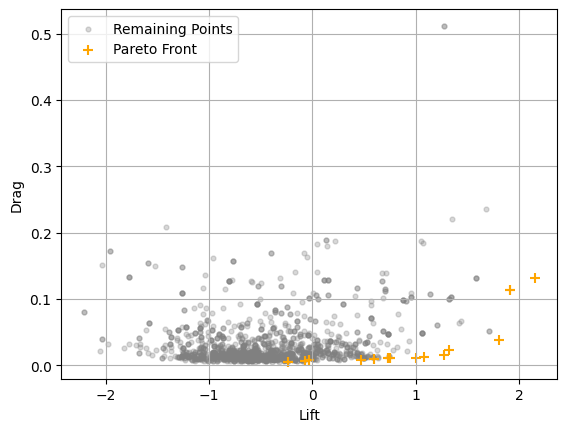

In [154]:
import os
import matplotlib.pyplot as plt

def load_population(folder="populations"):
    populations = {}
    
    for filename in os.listdir(folder):
        if filename.startswith("population_gen_") and filename.endswith(".txt"):
            gen_num = int(filename.split('_')[-1].split('.')[0])
            population = []
            
            with open(os.path.join(folder, filename), 'r') as file:
                for line in file:
                    if line.strip():
                        parts = line.strip().split('Fitness:')
                        individual_str = parts[0].strip()[1:-1]
                        fitness_str = parts[1].strip()[1:-1]
                        individual = list(map(float, individual_str.split(',')))
                        fitness = tuple(map(float, fitness_str.split(',')))
                        population.append((individual, fitness))
            
            populations[gen_num] = population
    
    return populations

def dominates(point1, point2):
    return (point1[0] >= point2[0] and point1[1] <= point2[1]) and (point1 != point2)

def pareto_front(points):
    pareto_points = []
    for i, point1 in enumerate(points):
        is_dominated = False
        for j, point2 in enumerate(points):
            if i != j and dominates(point2, point1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_points.append(point1)
    return pareto_points

# Load populations from the folder
populations = load_population()

lifts = []
drags = []
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            lifts.append(fit[0])
            drags.append(-fit[1])

# Combine the lists into a list of points
points = list(zip(lifts, drags))

# Find the Pareto front
pareto = pareto_front(points)

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]

# Plotting
plt.figure()
plt.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3, label="Remaining Points")
plt.scatter(pareto_l, pareto_d, color="orange", marker='+',s=50, label="Pareto Front")
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.legend()
plt.grid(True)
plt.show()


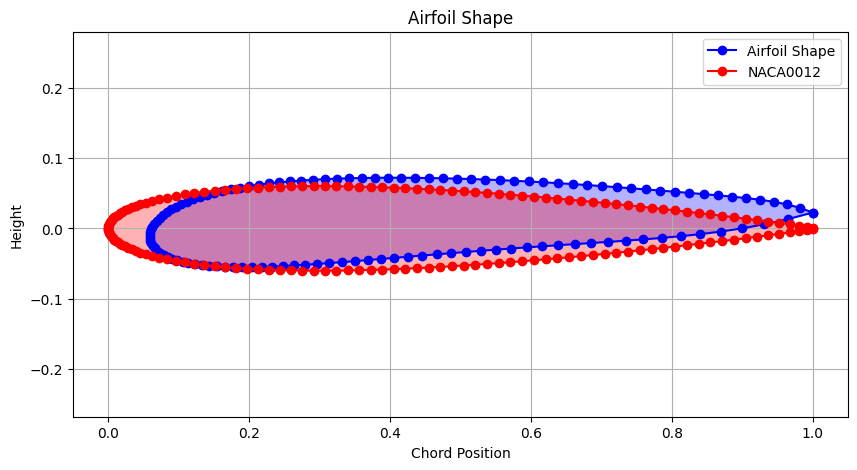

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.03656100854277611, drag : 0.007369525730609894


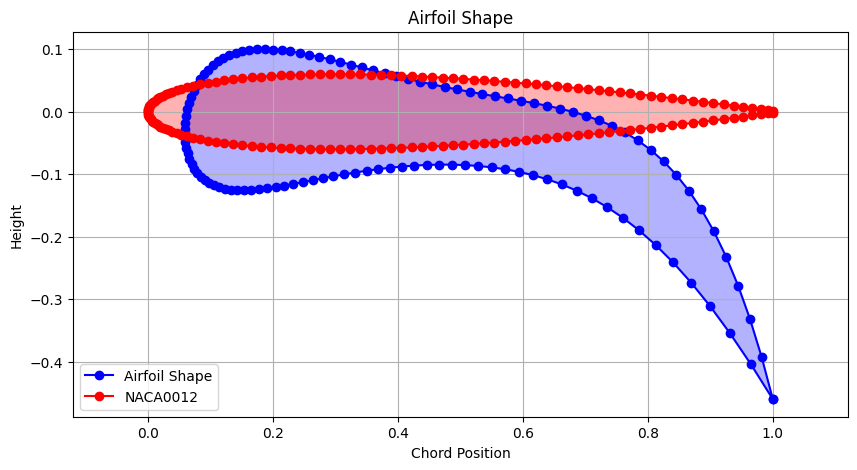

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 2.1519274711608887, drag : 0.13146381080150604


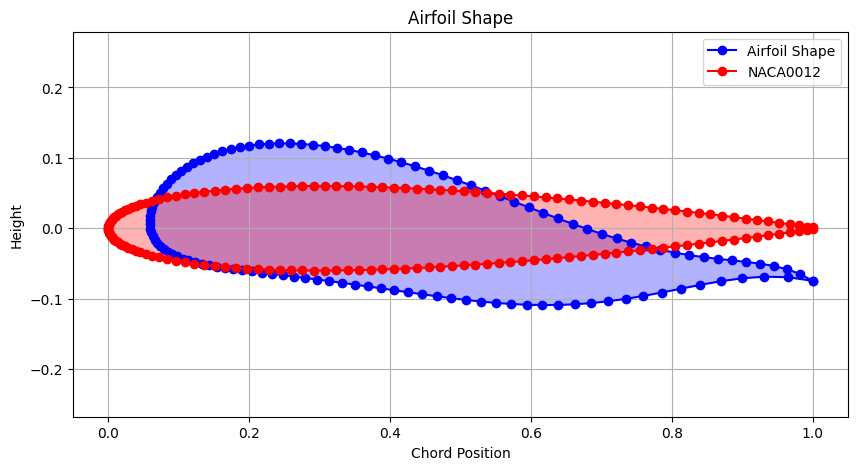

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.7471869587898254, drag : 0.01074259914457798


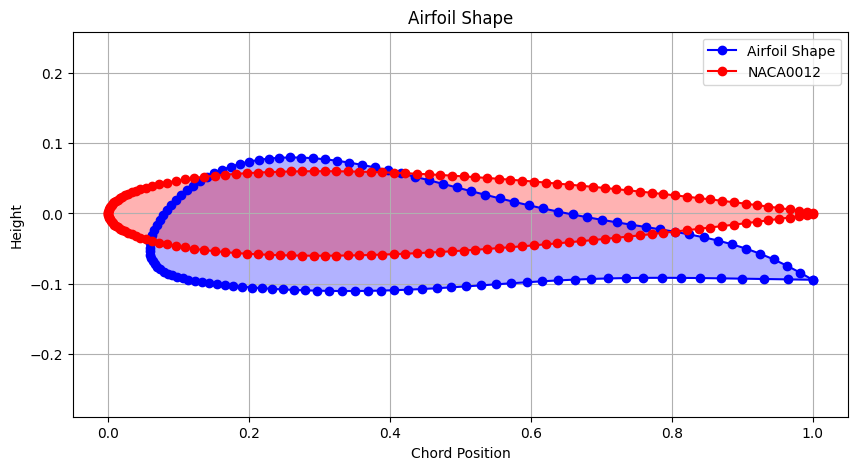

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.5939229130744934, drag : 0.010043438524007797


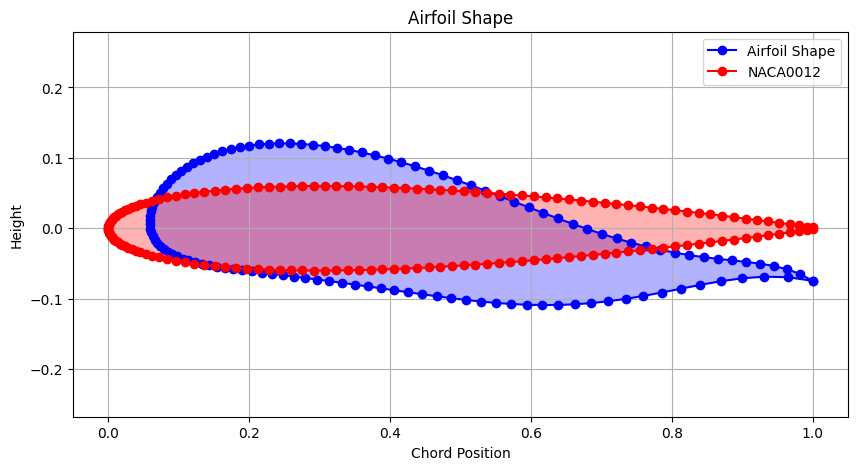

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.7471869587898254, drag : 0.01074259914457798


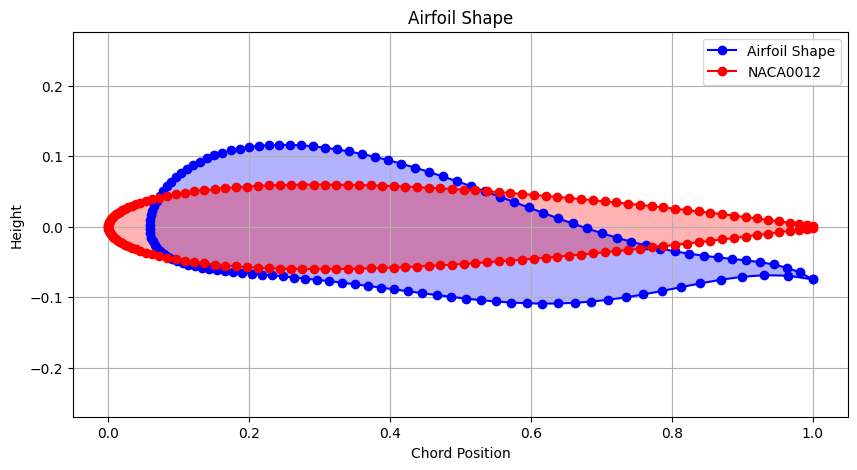

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.7296858429908752, drag : 0.010181975550949574


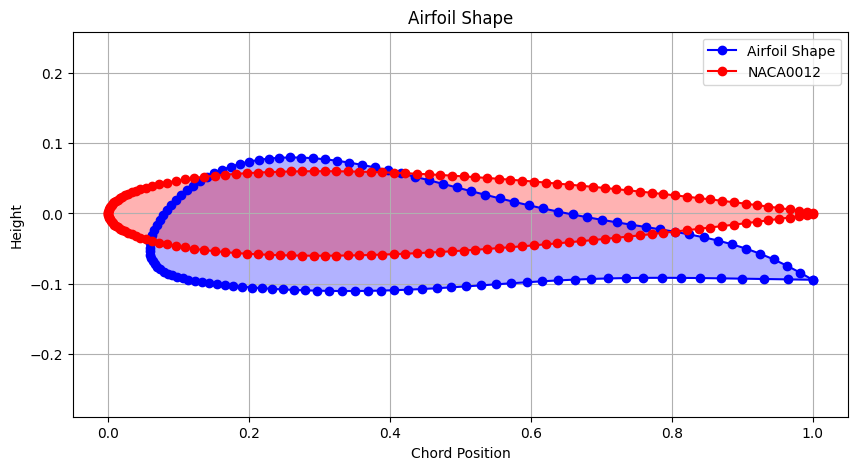

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.5939229130744934, drag : 0.010043438524007797


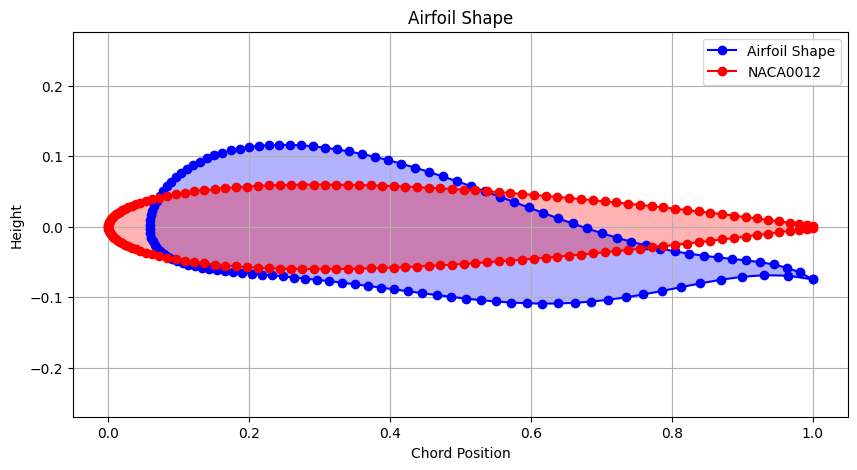

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.7296858429908752, drag : 0.010181975550949574


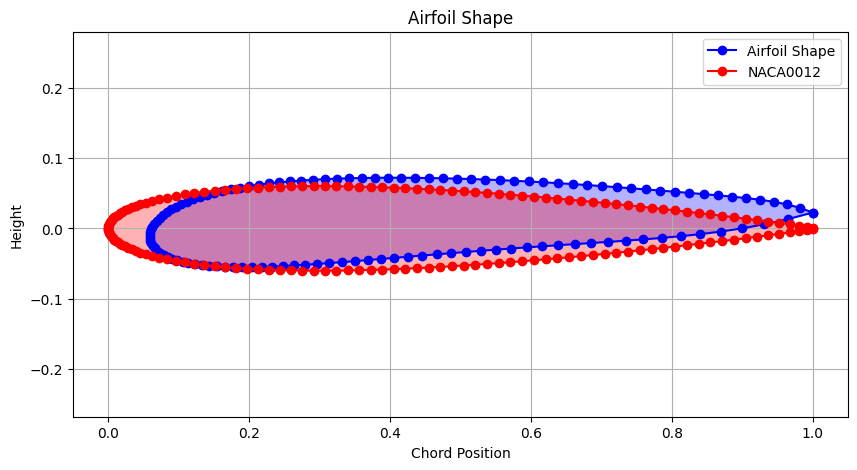

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.03656100854277611, drag : 0.007369525730609894


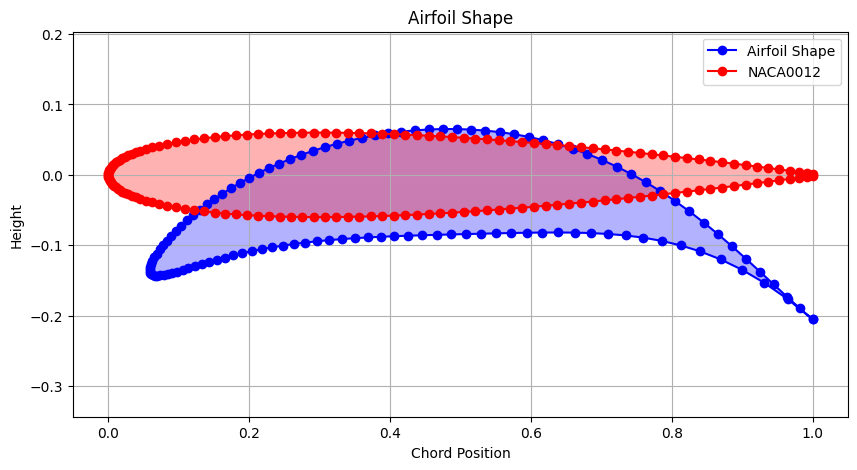

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 1.810314655303955, drag : 0.03809111937880516


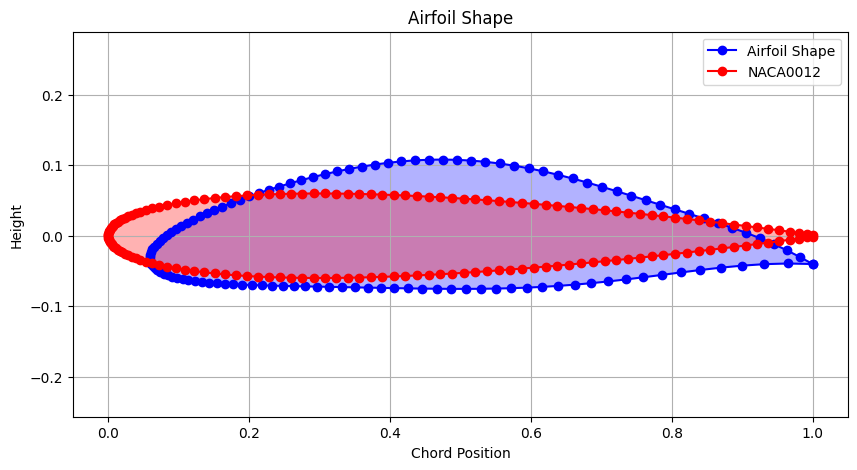

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.4686897397041321, drag : 0.007523598149418831


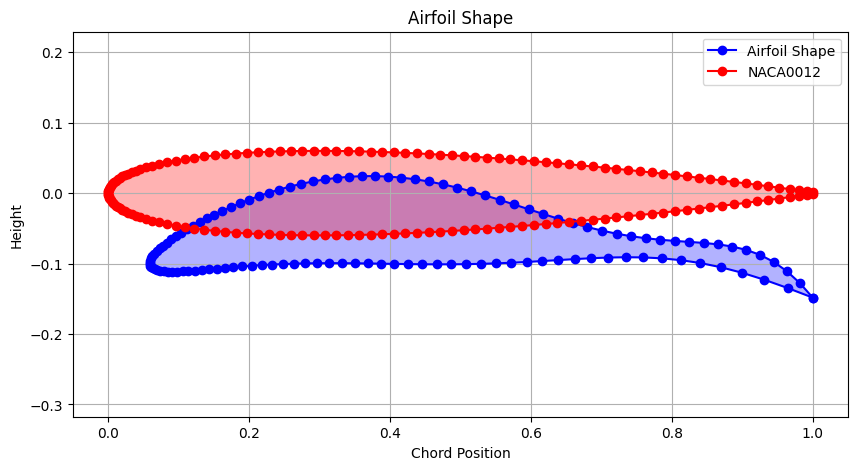

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 0.9983158111572266, drag : 0.01154112908989191


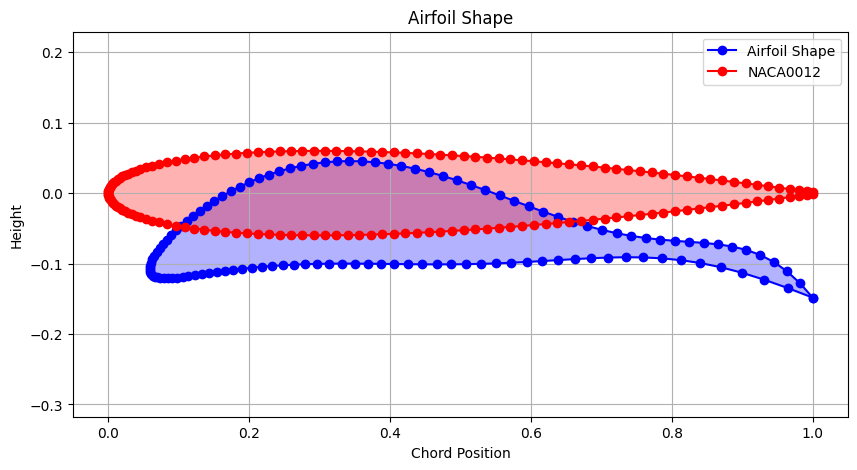

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 1.0845537185668945, drag : 0.012499110773205757


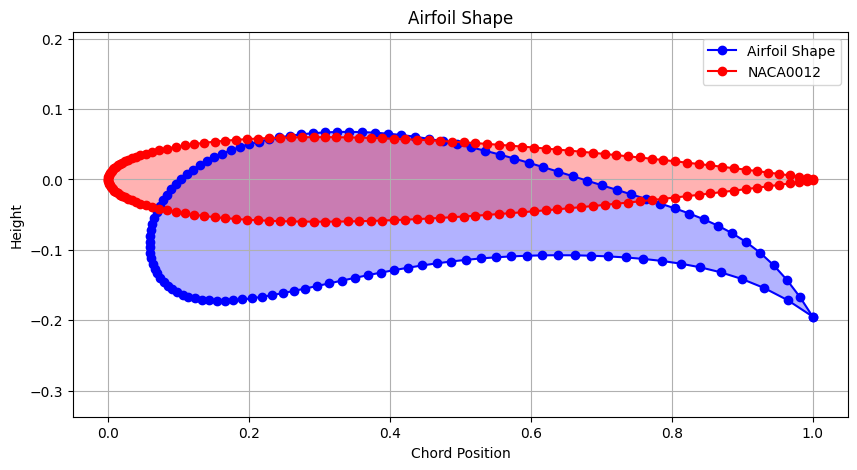

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 1.319986343383789, drag : 0.02364879846572876


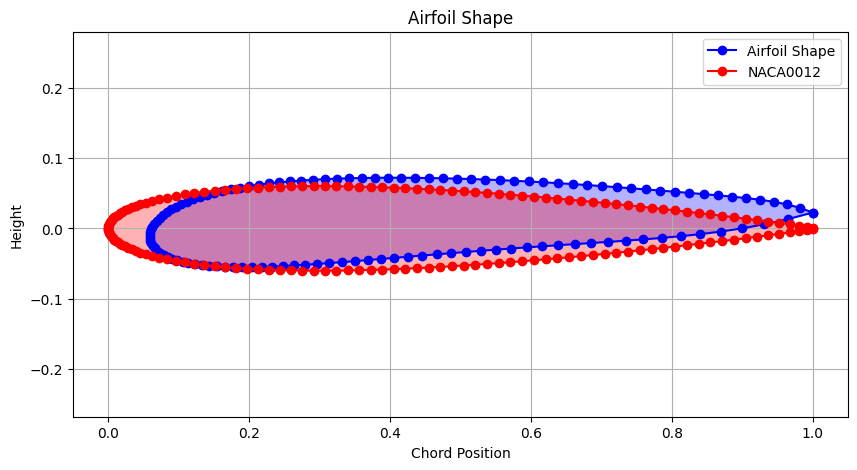

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.03656100854277611, drag : 0.007369525730609894


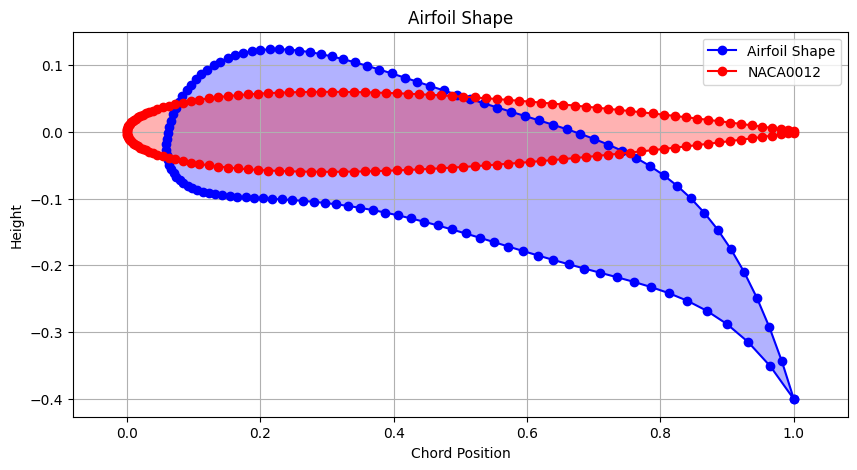

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 1.9171463251113892, drag : 0.11288310587406158


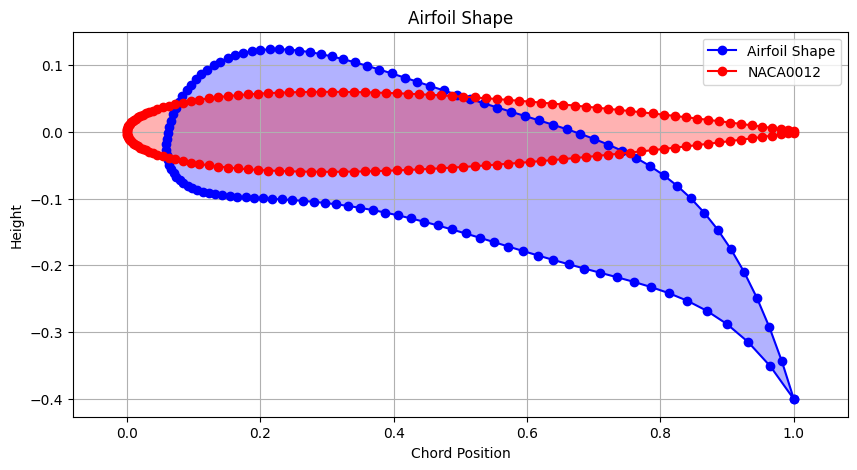

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 1.9171463251113892, drag : 0.11288310587406158


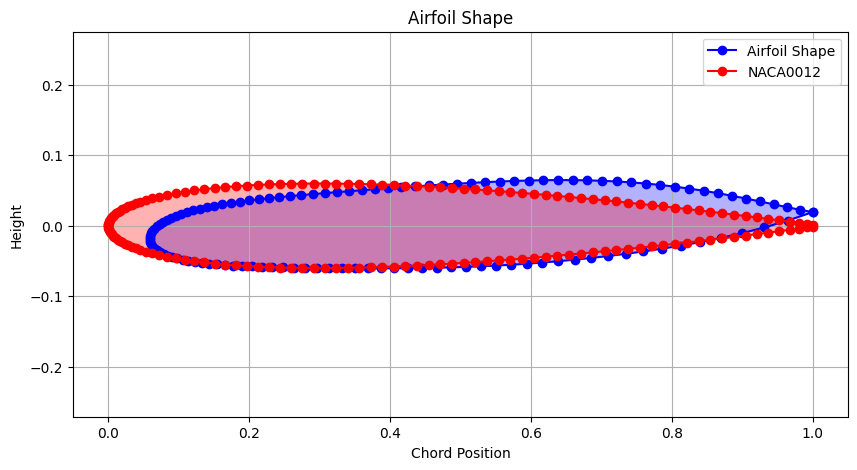

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.06828606128692627, drag : 0.005927862599492073


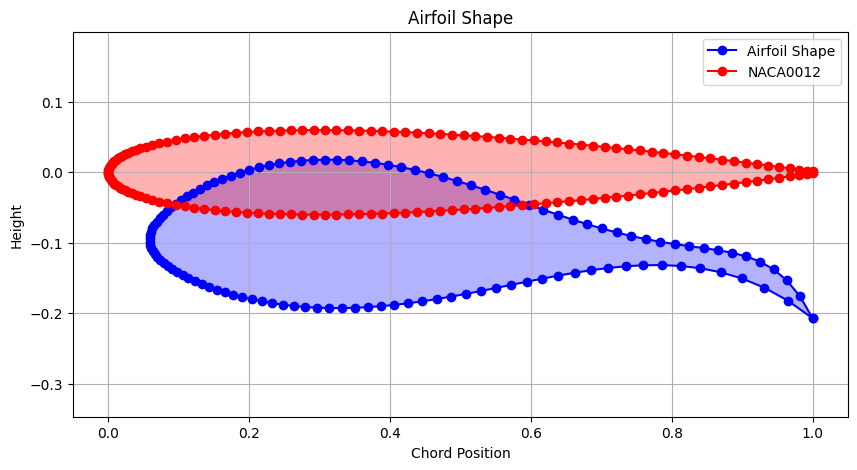

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift 1.2729322910308838, drag : 0.015551176853477955


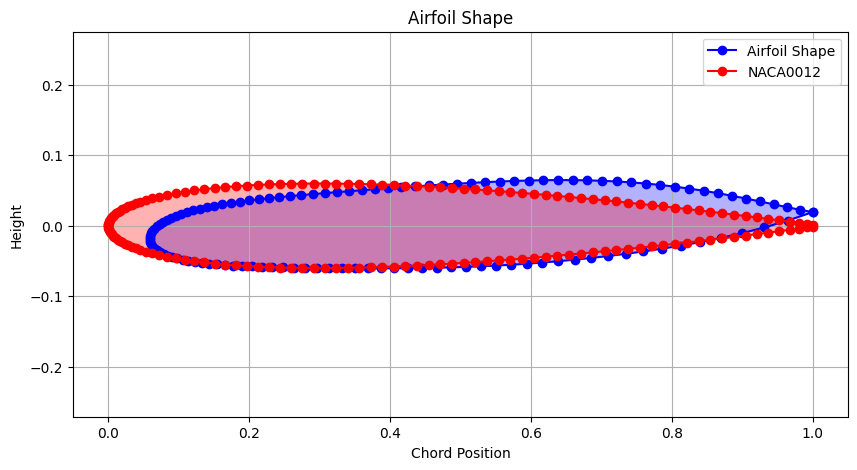

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.06828606128692627, drag : 0.005927862599492073


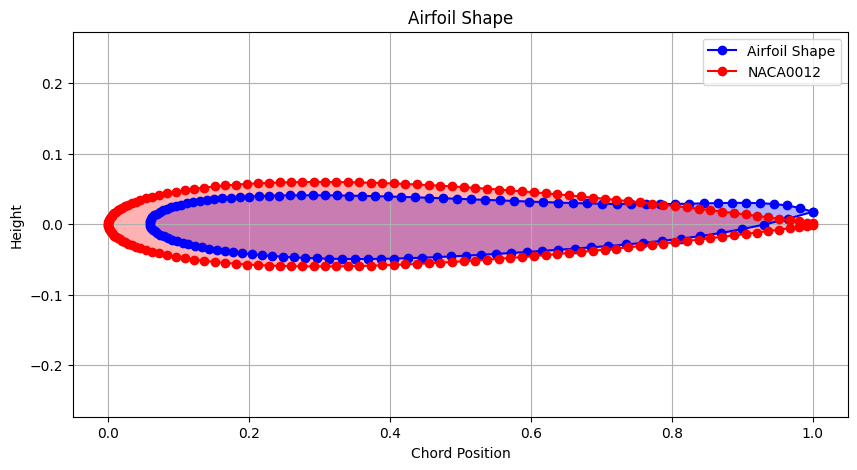

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.23364603519439697, drag : 0.004995882511138916


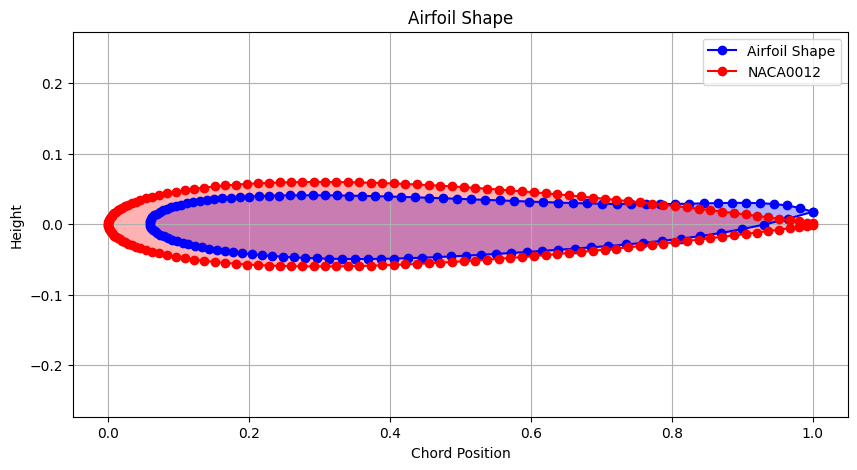

naca0012 fitness : lift 4.477630266563892e-09, drag : 0.005404532887041569
best indiv fitness : lift -0.23364603519439697, drag : 0.004995882511138916


In [155]:
for gen, population in populations.items():
    for ind, fit in population:
        if fit[0] != 0 and fit[1] != -1e5:
            if fit[0] in pareto_l:
                best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
                best, foil = airfoil(best_indiv,  n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
                plot_foil(best)
                naca0012_fit = np.array(fitness(naca0012))
                print(f"naca0012 fitness : lift {naca0012_fit[0]}, drag : {naca0012_fit[1]}")
                print(f"best indiv fitness : lift {fit[0]}, drag : {-fit[1]}")

                
